<a href="https://colab.research.google.com/github/juliaguardiani/test_ITM_BRASIL/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.8 MB/s 
     |████████████████████████████████| 181 kB 53.6 MB/s 
     |████████████████████████████████| 145 kB 30.1 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=cf08cfa27b51fdfd9d31d282c9bcf16b7949b926a5f6d5982ff38b51d7c7b2b5
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import logging
import pandas as pd
import wandb
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
# Login to Weights & Biases
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **1.0 Test evaluation**

In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

In [5]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "decision_tree/test.csv:latest"

# name of the model artifact
artifact_model_name = "decision_tree/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name = "decision_tree/target_encoder:latest"

In [6]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [8]:
# initiate the wandb project
run = wandb.init(project="decision_tree",job_type="test")

In [10]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("label")

02-06-2022 22:24:12 Downloading and reading test artifact
02-06-2022 22:24:13 Extracting target from dataframe


In [11]:
# Takes a look at test set
x_test.head()

,antiss,AV,BA,BC,DRML,dresc,DI,EEG,EC,ES,...,SS_02,SMB.1,subc_02,TC_02,TEC_02,TI_02,usuAgua_02,total_01,total_02,total_03
0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1,0.25,0.25,0.0,0.00,0.25,0.25,0.00,0.00,0.00,0.25,...,0.5,0.0,0.0,0.0,0.0,0.5,0.0,2.75,4.00,3.0
2,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
3,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.50,0.5
4,0.25,0.25,0.0,0.25,0.25,0.25,0.25,0.25,0.25,0.25,...,0.5,0.5,0.5,0.0,0.5,0.5,0.5,4.00,7.25,11.5


In [12]:
# Take a look at the target variable
y_test.head()

0    1
1    2
2    1
3    1
4    0
Name: label, dtype: int64

In [13]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

02-06-2022 22:24:38 Extracting the encoding of the target variable


In [15]:
# transform y_train
y_test = le.transform(y_test)
logger.info("Classes [0, 1, 2]: {}".format(le.inverse_transform([0, 1, 2])))

02-06-2022 22:24:50 Classes [0, 1, 2]: [0 1 2]


In [16]:
# target variable after the encoding
y_test

array([1, 2, 1, 1, 0, 1, 1, 0, 0, 2])

In [17]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

02-06-2022 22:25:11 Downloading and load the exported model


In [18]:
# predict
logger.info("Infering")
predict = pipe.predict(x_test)

# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(y_test, predict, beta=1, zero_division=1, average='micro')
precision = precision_score(y_test, predict, zero_division=1, average='micro')
recall = recall_score(y_test, predict, zero_division=1, average='micro')
acc = accuracy_score(y_test, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

02-06-2022 22:26:15 Infering
02-06-2022 22:26:15 Test Evaluation metrics
02-06-2022 22:26:15 Test Accuracy: 1.0
02-06-2022 22:26:15 Test Precision: 1.0
02-06-2022 22:26:15 Test Recall: 1.0
02-06-2022 22:26:15 Test F1: 1.0


In [19]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



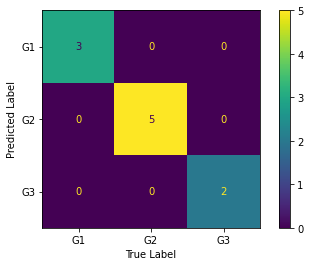

In [20]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(y_test,predict,labels=[0,1,2]),
                       display_labels=["G1","G2", "G3"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [21]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

02-06-2022 22:27:24 Uploading figures


In [22]:
run.finish()

Acc,1.0
F1,1.0
Precision,1.0
Recall,1.0
